In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier , plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
import matplotlib.pyplot as plt
import xgboost as xgb


# Read the math placement data from the Excel file
df_math_placement = pd.read_excel('math_placement.xlsx')

# Read the edready raw scores data from the CSV file
df_ed_ready = pd.read_csv('edready_raw_scores.csv')


In [9]:

# Remove records without hs_gpa information
df_cleaned = df_math_placement.dropna(subset=['grade', 'hs_gpa']).copy()

# Define the mapping of grades to grade categories
grade_mapping = {
    "A": "Successful", "B": "Successful", "B+": "Successful",
    "A-": "Successful", "B*": "Successful", "A*": "Successful",
    "B+*": "Successful", "W": "Withdrawn", "C-": "Unsuccessful",
    "F": "Unsuccessful", "B-": "Successful", "C+": "Unsuccessful",
    "D": "Unsuccessful", "D*": "Unsuccessful", "C": "Unsuccessful",
    "W*": "Withdrawn", "P*": "Successful", "C+*": "Unsuccessful",
    "F*": "Unsuccessful", "D+": "Unsuccessful", "P": "Successful",
    "C*": "Unsuccessful", "A-*": "Successful", "I": "Withdrawn",
    "AU": "Withdrawn", "B-*": "Successful", "D-": "Unsuccessful",
    "NR": "Withdrawn", "C-*": "Unsuccessful", "I*": "Withdrawn",
    "NR*": "Withdrawn"
}

# Map the grades to their categories and append as a new column
df_cleaned.loc[:, 'grade_category'] = df_cleaned['grade'].map(grade_mapping)

# Make sure the column names match in both dataframes before merging
df_cleaned.rename(columns={'pidm': 'PIDM'}, inplace=True)

# Display the cleaned and imputed dataframe
df_cleaned.head()


,Row,PIDM,term_code,admit_term,degree.x,major_code,college.x,major.x,stu_type,stu_level.x,...,campus_code,course_number,section_number,subj_code,section_type,credit_levl,course_credits,reg_status,grade,grade_category
7,29,149852,202070,202070.0,Associate of Arts,AA,Gallatin College,Associate of Arts,T,UG,...,ZGC,090,922,M,L,UG,4,RE,B*,Successful
8,30,149852,202070,202070.0,Associate of Arts,AA,Gallatin College,Associate of Arts,T,UG,...,ZGC,063,922,M,L,UG,1,RE,A*,Successful
9,35,210982,202230,202230.0,Bachelor of Science,NURS,College of Nursing,Nursing,T,UG,...,Z,216Q,2,STAT,L,UG,3,RW,B,Successful
10,36,210982,202030,202030.0,Associate of Science,AS,Gallatin College,Associate of Science,N,UG,...,Z,216Q,2,STAT,L,UG,3,RW,B,Successful
24,60,452703,202230,202230.0,Bachelor of Science,PNUR,College of Nursing,Pre-Nursing,N,UG,...,Z,121Q,12,M,L,UG,3,RW,B+,Successful


In [10]:
# Trim whitespace from headers
df_cleaned.columns = df_cleaned.columns.str.strip()
df_ed_ready.columns = df_ed_ready.columns.str.strip()

# Now attempt the merge again
df_merged = pd.merge(df_cleaned, df_ed_ready[['PIDM', 'ERM_SCORE']], on='PIDM', how='left')

# Display the merged dataframe
df_merged.head()

,Row,PIDM,term_code,admit_term,degree.x,major_code,college.x,major.x,stu_type,stu_level.x,...,course_number,section_number,subj_code,section_type,credit_levl,course_credits,reg_status,grade,grade_category,ERM_SCORE
0,29,149852,202070,202070.0,Associate of Arts,AA,Gallatin College,Associate of Arts,T,UG,...,090,922,M,L,UG,4,RE,B*,Successful,10.0
1,30,149852,202070,202070.0,Associate of Arts,AA,Gallatin College,Associate of Arts,T,UG,...,063,922,M,L,UG,1,RE,A*,Successful,10.0
2,35,210982,202230,202230.0,Bachelor of Science,NURS,College of Nursing,Nursing,T,UG,...,216Q,2,STAT,L,UG,3,RW,B,Successful,NaN
3,36,210982,202030,202030.0,Associate of Science,AS,Gallatin College,Associate of Science,N,UG,...,216Q,2,STAT,L,UG,3,RW,B,Successful,NaN
4,60,452703,202230,202230.0,Bachelor of Science,PNUR,College of Nursing,Pre-Nursing,N,UG,...,121Q,12,M,L,UG,3,RW,B+,Successful,30.0


In [11]:
# Remove records where 'ERM_SCORE' is NaN
df_merged_cleaned = df_merged.dropna(subset=['ERM_SCORE'])

# Display the dataframe without NaN records in 'ERM_SCORE'
df_merged_cleaned.head()


,Row,PIDM,term_code,admit_term,degree.x,major_code,college.x,major.x,stu_type,stu_level.x,...,course_number,section_number,subj_code,section_type,credit_levl,course_credits,reg_status,grade,grade_category,ERM_SCORE
0,29,149852,202070,202070.0,Associate of Arts,AA,Gallatin College,Associate of Arts,T,UG,...,090,922,M,L,UG,4,RE,B*,Successful,10.0
1,30,149852,202070,202070.0,Associate of Arts,AA,Gallatin College,Associate of Arts,T,UG,...,063,922,M,L,UG,1,RE,A*,Successful,10.0
4,60,452703,202230,202230.0,Bachelor of Science,PNUR,College of Nursing,Pre-Nursing,N,UG,...,121Q,12,M,L,UG,3,RW,B+,Successful,30.0
7,71,702012,202270,202270.0,Associate of Science,AS,Gallatin College,Associate of Science,N,UG,...,021,916,M,L,UG,2,RW,P*,Successful,10.0
8,72,702012,202270,202270.0,Associate of Science,AS,Gallatin College,Associate of Science,N,UG,...,121Q,916,M,L,UG,3,RW,B,Successful,10.0


## Model 1: Logistic Regression Model - ERM Score & High School GPA as Predictor Variables & Grade Category as Target Variable

In [44]:
#Filter out 'Withdrawn' grade_category
df_filtered = df_merged_cleaned[df_merged_cleaned['grade_category'] != 'Withdrawn']

#Prepare the data
X = df_filtered[[ 'hs_gpa','ERM_SCORE',]]
y = df_filtered['grade_category']

# Ensure no NaN values in predictors
X = X.dropna()

# Since 'grade_category' is categorical, we need to encode it
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y.loc[X.index])  # Ensure alignment with X after dropping NaN

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# Train a logistic regression model
log_reg = LogisticRegression(max_iter=1000)  # Increase max_iter if convergence warning
log_reg.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Accuracy: 0.66
              precision    recall  f1-score   support

  Successful       0.67      0.88      0.76      2458
Unsuccessful       0.62      0.33      0.43      1547

    accuracy                           0.66      4005
   macro avg       0.65      0.60      0.60      4005
weighted avg       0.66      0.66      0.63      4005



## Model 2: Logistic Regression Model - ERM Score as Predictor Variable & Grade Category as Target Variable

In [45]:

#  Prepare the data, only ERM_SCORE is used as a predictor
X = df_filtered[['ERM_SCORE']].dropna()
y = df_filtered.loc[X.index, 'grade_category']  # Ensure alignment with X

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# Train a logistic regression model with class_weight='balanced'
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(X_train, y_train)

#  Predict and evaluate the model
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Adjust classification_report to handle zero division
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=0))



Accuracy: 0.56
              precision    recall  f1-score   support

  Successful       0.63      0.69      0.65      2458
Unsuccessful       0.41      0.35      0.38      1547

    accuracy                           0.56      4005
   macro avg       0.52      0.52      0.51      4005
weighted avg       0.54      0.56      0.55      4005



## Model 3: Random Forest

In [46]:
# Prepare the data
X = df_filtered[['hs_gpa', 'ERM_SCORE']]
y = df_filtered['grade_category']


# Splitting the dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Detailed classification report
print(classification_report(y_test, y_pred))


Accuracy: 0.69
              precision    recall  f1-score   support

  Successful       0.71      0.83      0.77      1649
Unsuccessful       0.62      0.46      0.53      1021

    accuracy                           0.69      2670
   macro avg       0.67      0.64      0.65      2670
weighted avg       0.68      0.69      0.67      2670



## Model 4:  Decision Tree

In [30]:
# Making a copy of the dataframe to avoid SettingWithCopyWarning
df_merged_cleaned = df_merged_cleaned.copy()

# Encode the target variable 'course_number'
course_number_encoder = LabelEncoder()
df_merged_cleaned['course_number_encoded'] = course_number_encoder.fit_transform(df_merged_cleaned['course_number'])

# Predictors
X = df_merged_cleaned[['hs_gpa', 'ERM_SCORE']]

# Target variable is'course_number_encoded'
y_course_number = df_merged_cleaned['course_number_encoded']

# Split the data into training and testing sets
X_train, X_test, y_train_course_number, y_test_course_number = train_test_split(X, y_course_number, test_size=0.3, random_state=42)

# Initialize the DecisionTreeClassifier with parameters to control tree complexity
clf_course_number = DecisionTreeClassifier(
    max_depth=5,               # Limit the depth of the tree
    min_samples_split=40,      # Require at least 40 samples to split a node
    min_samples_leaf=20,       # Each leaf node must contain at least 20 samples
    max_leaf_nodes=15,         # Limit the total number of leaf nodes
    random_state=42
)
# Fit the classifier to the training data
clf_course_number.fit(X_train, y_train_course_number)

# Predict on the test data
y_pred_course_number = clf_course_number.predict(X_test)


In [31]:
# Decode the predicted course numbers back to the original encoding
predicted_courses = course_number_encoder.inverse_transform(y_pred_course_number)

# Add the predicted courses to your test DataFrame
X_test.loc[:, 'predicted_course_number'] = predicted_courses

# Join the original 'grade_category' to the test DataFrame for evaluation
X_test = X_test.join(df_merged_cleaned['grade_category'], how='left')

# Evaluate the success by checking the grade_category of the predicted placements
# For example, you can calculate the proportion of 'Successful' placements
successful_placements = X_test[X_test['grade_category'] == 'Successful']
success_rate = len(successful_placements) / len(X_test)
print(f'Success rate of placements: {success_rate:.2f}')


Success rate of placements: 0.54


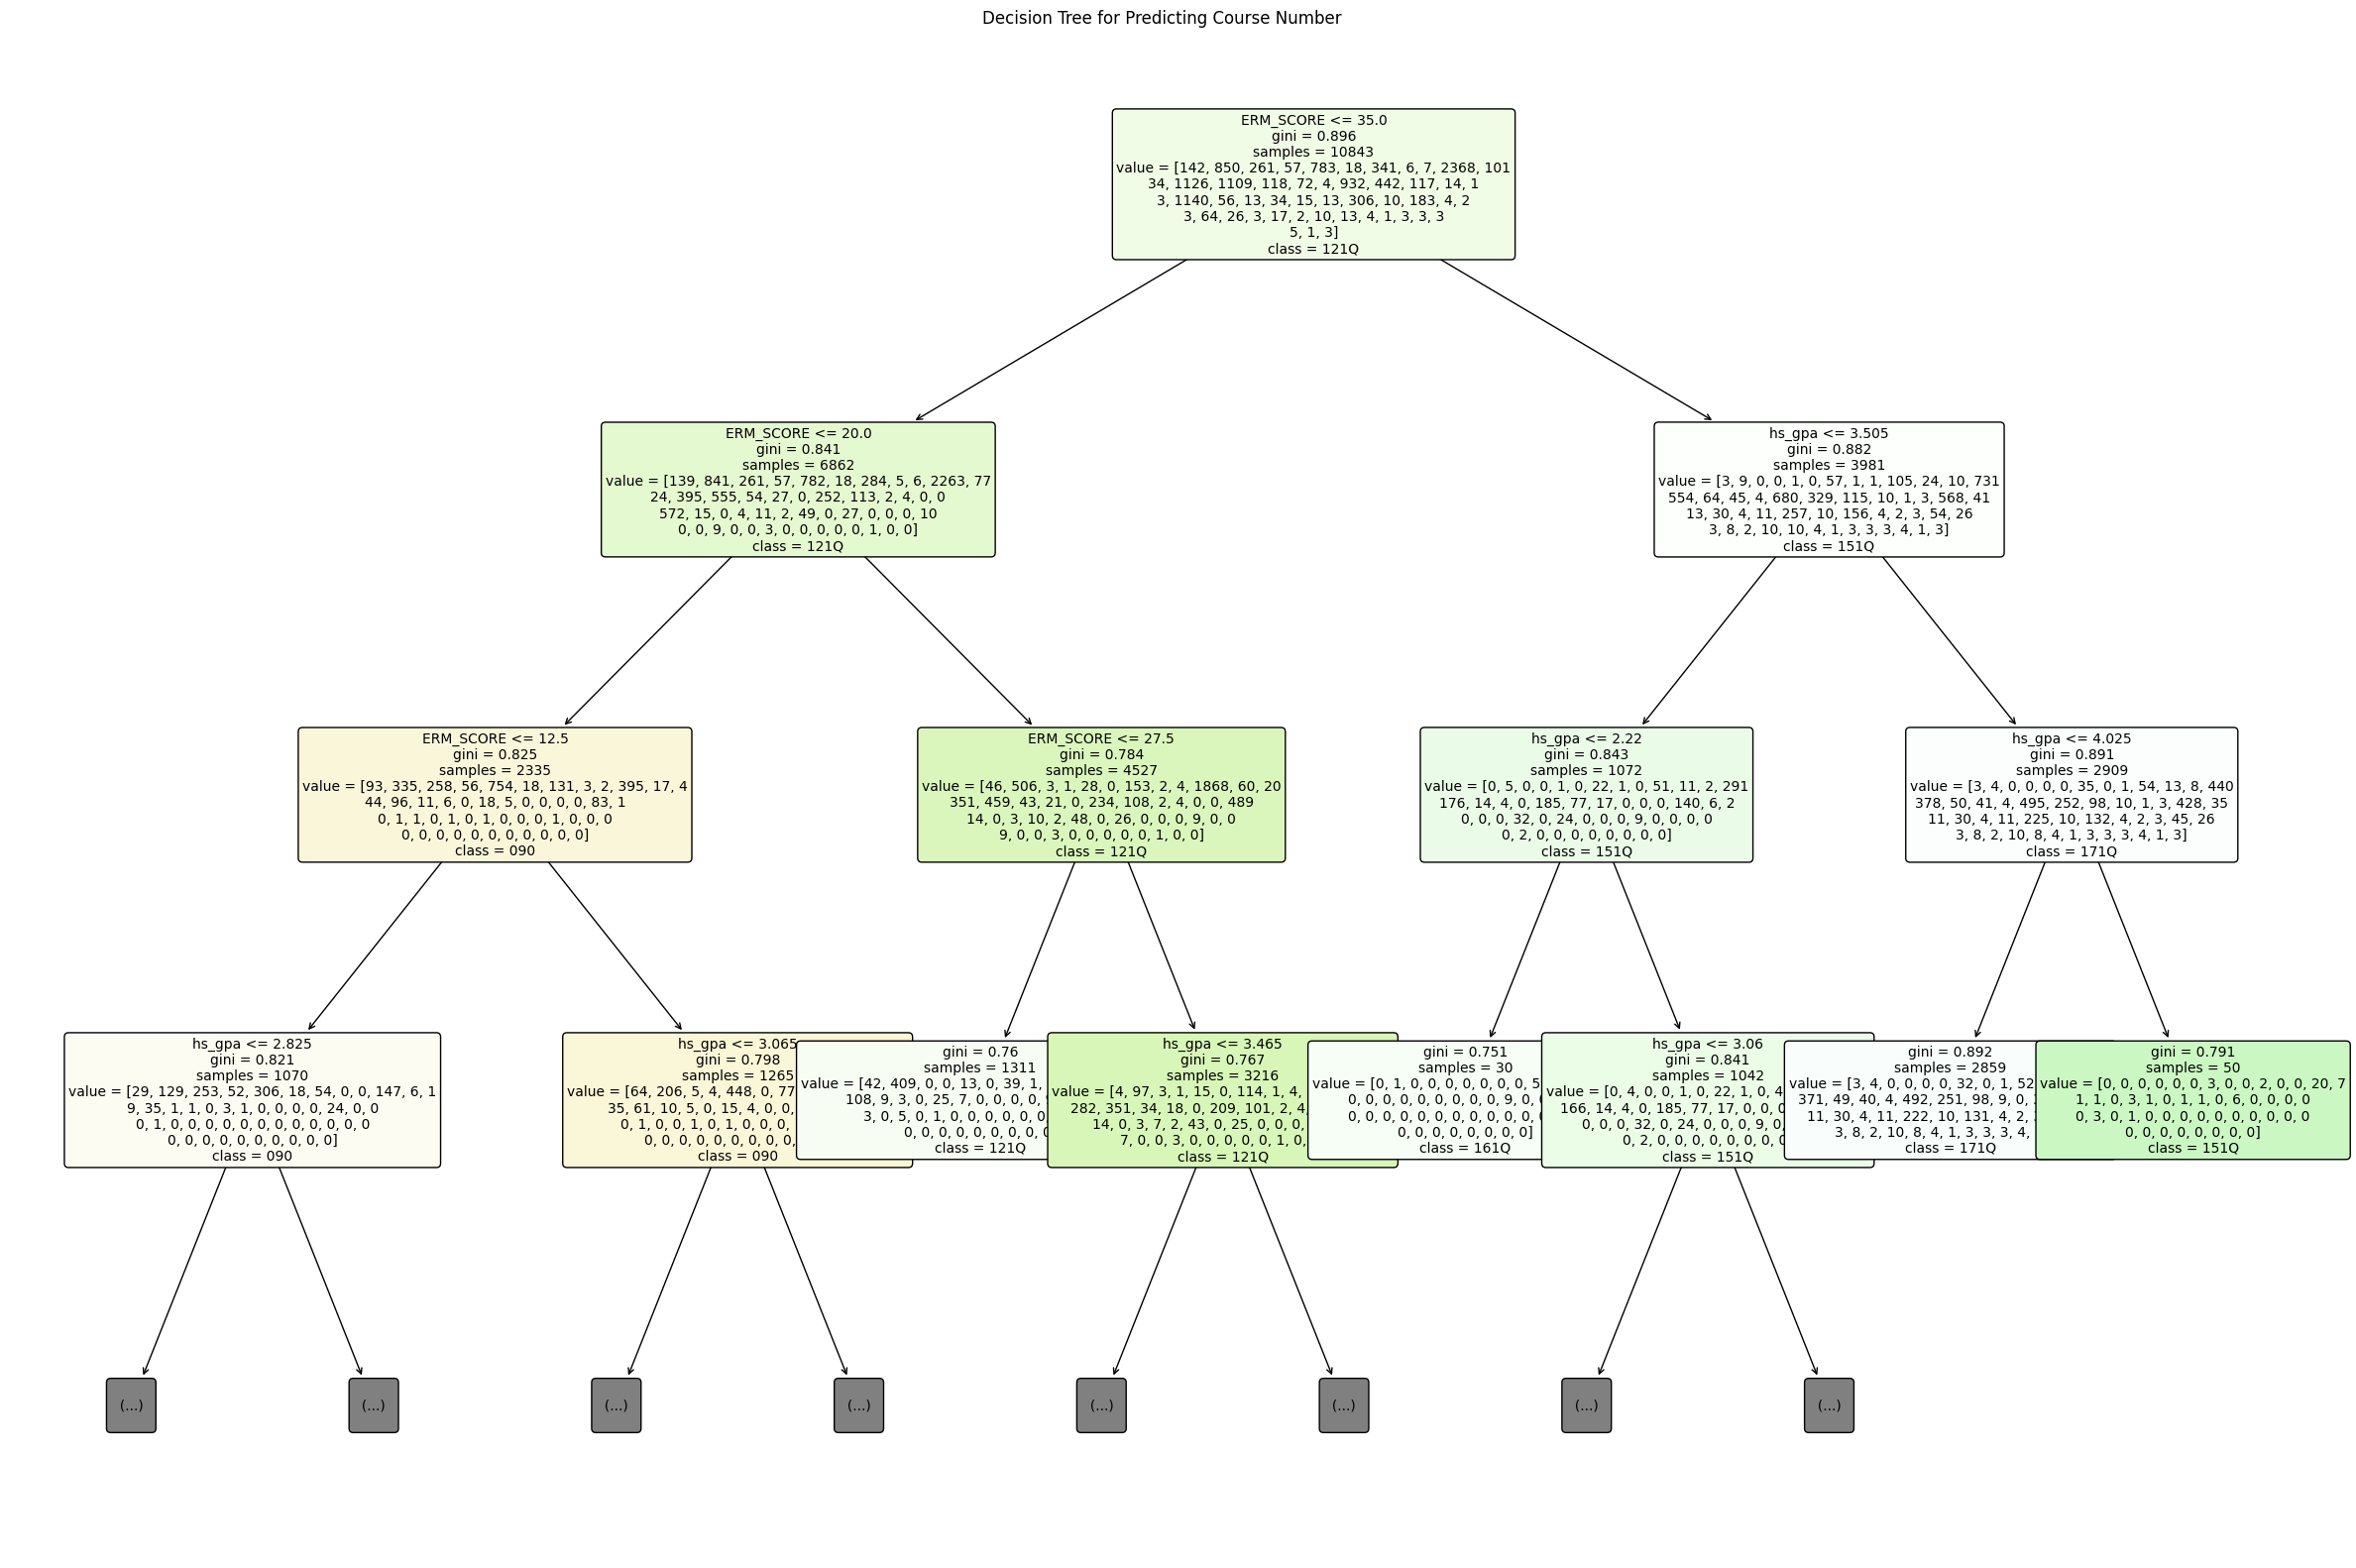

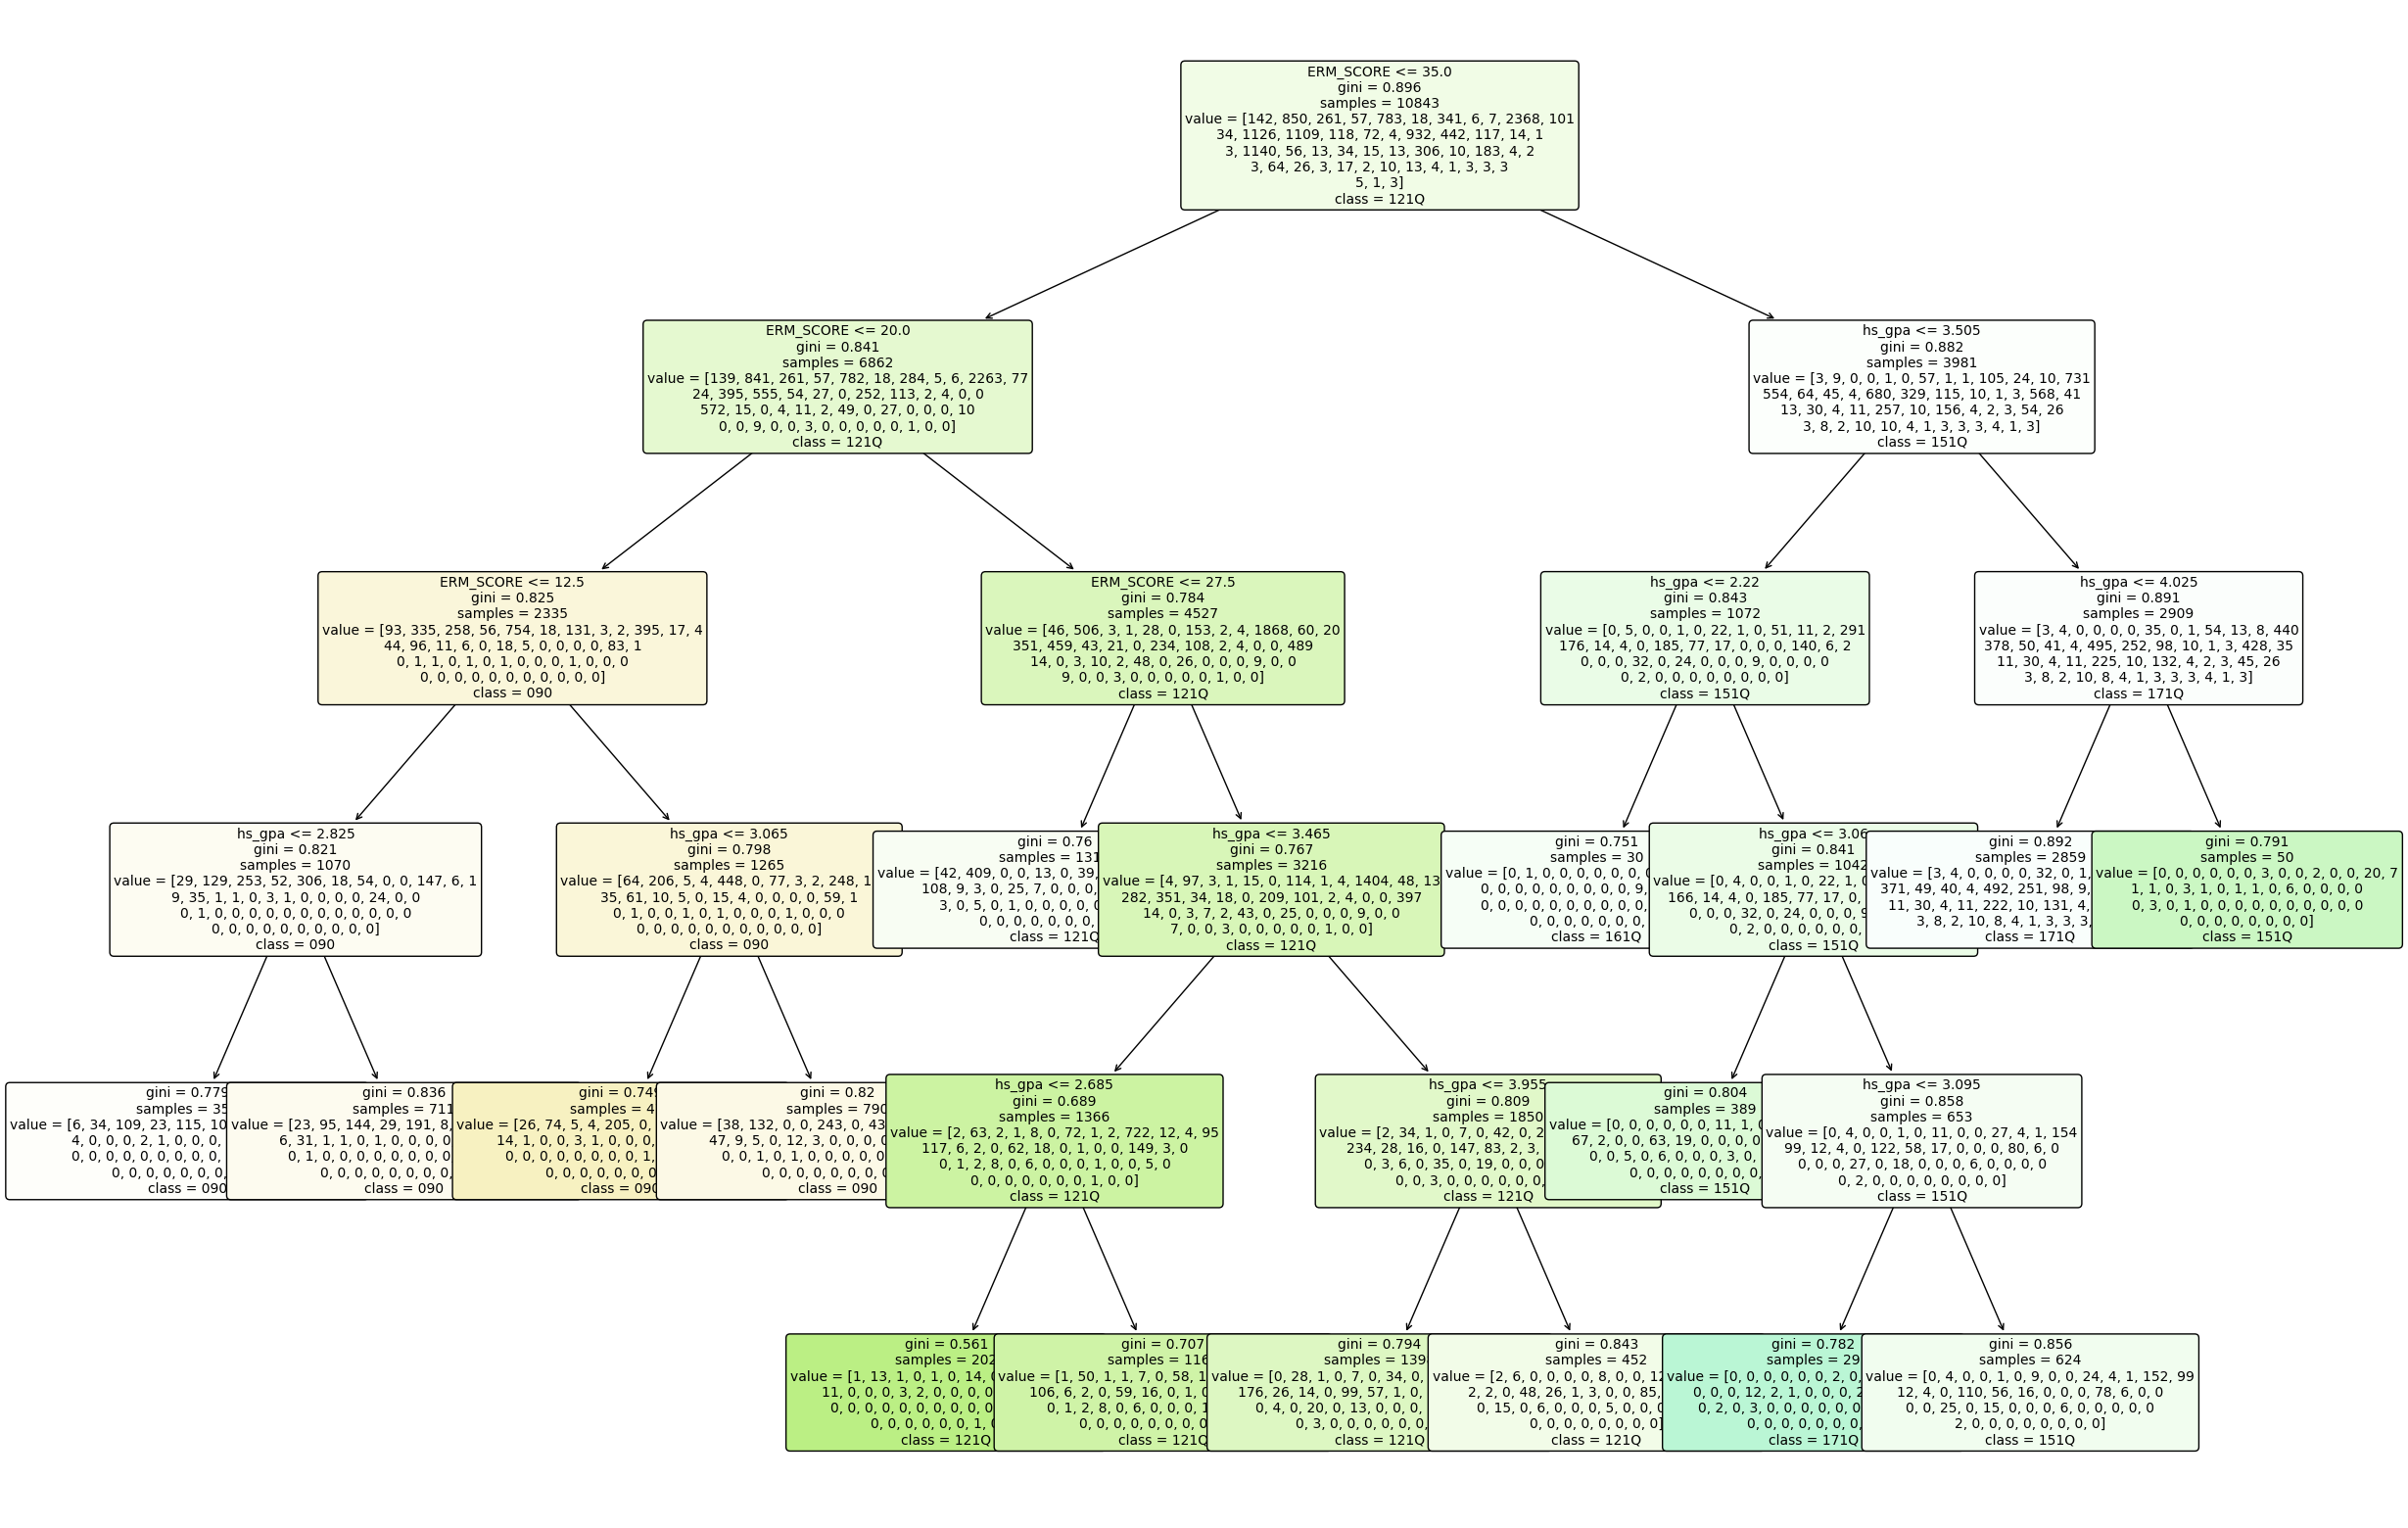

In [32]:

# Increase figure size
plt.figure(figsize=(30, 20))  # Adjust the figure size as needed

# Plot the decision tree with limited depth for better readability
decision_tree_plot = plot_tree(clf_course_number, 
                               feature_names=['hs_gpa', 'ERM_SCORE'], 
                               class_names=course_number_encoder.classes_.astype(str), 
                               filled=True, 
                               rounded=True,
                               max_depth=3,  # Show more depth if needed and if space allows
                               fontsize=10)  # Adjust font size for better readability

plt.title('Decision Tree for Predicting Course Number')
plt.show()

# Optionally, save the figure to a file for detailed inspection
plt.figure(figsize=(30, 20))  # Redefine figure size for the saved image
plot_tree(clf_course_number, 
          feature_names=['hs_gpa', 'ERM_SCORE'], 
          class_names=course_number_encoder.classes_.astype(str), 
          filled=True, 
          rounded=True,
          max_depth=None,  # Consider showing the full tree depth when saving to file
          fontsize=10)
plt.savefig('decision_tree_full.png', format='png', bbox_inches='tight')  # Save to file



In [36]:
#Clean the data
df_merged_cleaned = df_merged_cleaned.dropna(subset=['ERM_SCORE', 'course_number'])

#Filter out classes with only one instance
class_counts = df_merged_cleaned['course_number'].value_counts()
df_filtered = df_merged_cleaned[df_merged_cleaned['course_number'].isin(class_counts[class_counts > 1].index)].copy()

#Encode the target variable
course_number_encoder = LabelEncoder()
df_filtered['course_number_encoded'] = course_number_encoder.fit_transform(df_filtered['course_number'])

#Perform stratified split
X = df_filtered[['ERM_SCORE', 'hs_gpa']]
y = df_filtered['course_number_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

#Initialize XGBoost classifier for course_number prediction
xgb_model_course_number = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

#Fit the model to the training data
xgb_model_course_number.fit(X_train, y_train)

#Predict on the test data
y_pred_course_number = xgb_model_course_number.predict(X_test)

#Evaluate the predictions by decoding them back to the original course numbers
predicted_course_numbers = course_number_encoder.inverse_transform(y_pred_course_number)

#Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_course_number)  # Compare encoded labels directly
print(f'Accuracy of the XGBoost model for course number prediction: {accuracy:.2f}')


Accuracy of the XGBoost model for course number prediction: 0.28
